In [27]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
GRAIN_TYPE = 'Wheat'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
df = pd.get_dummies(df, columns=['Variety'])
# Drop any columns that are 'Unnamed: X'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.drop('Phase', axis=1)
df = df.drop('Attn', axis=1)
df = df.drop('Density', axis=1)
df['d(cm)'] = df['d(cm)'].astype('category')

# Apply one-hot encoding to 'd(cm)' because it is only ever four differne values
df = pd.get_dummies(df, columns=['d(cm)'])
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df)

# Generator
def build_generator(latent_dim):
    model = Sequential([
        Dense(256, use_bias=False, input_dim=latent_dim),
        BatchNormalization(),
        LeakyReLU(),
        Dense(512),
        BatchNormalization(),
        LeakyReLU(),
        Dense(1024),
        BatchNormalization(),
        LeakyReLU(),
        Dense(np.prod(df.shape[1]), activation='tanh'),
        Reshape((df.shape[1],))
    ])
    return model

# Discriminator
def build_discriminator(input_shape):
    model = Sequential([
        Flatten(input_shape=(input_shape,)),
        Dense(512),
        LeakyReLU(),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

latent_dim = 100  # You can experiment with this value
generator = build_generator(latent_dim)
discriminator = build_discriminator(df.shape[1])

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Combined model (generator + discriminator)
discriminator.trainable = False  # For the combined model, only train the generator

gan_input = tf.keras.Input(shape=(latent_dim,))
fake_data = generator(gan_input)
gan_output = discriminator(fake_data)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training loop
def train_gan(generator, discriminator, gan, scaled_data, epochs=10000, batch_size=32, latent_dim=100):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, scaled_data.shape[0], batch_size)
        real_data = scaled_data[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_data = generator.predict(noise)
        
        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_data, real_y)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

train_gan(generator, discriminator, gan, scaled_data, epochs=20000, batch_size=32, latent_dim=latent_dim)

1/1 [==============================] - 0s 46ms/step
Epoch: 0 [D loss: 0.7354679703712463] [G loss: 0.750715970993042]
1/1 [==============================] - 0s 8ms/step
Epoch: 1000 [D loss: 0.6248062551021576] [G loss: 1.135481595993042]
1/1 [==============================] - 0s 8ms/step
Epoch: 2000 [D loss: 0.5371907353401184] [G loss: 1.0992733240127563]
1/1 [==============================] - 0s 8ms/step
Epoch: 3000 [D loss: 0.6073636412620544] [G loss: 1.1774098873138428]
1/1 [==============================] - 0s 7ms/step
Epoch: 4000 [D loss: 0.5489916205406189] [G loss: 1.2178547382354736]
1/1 [==============================] - 0s 8ms/step
Epoch: 5000 [D loss: 0.5622688233852386] [G loss: 1.47898530960083]
1/1 [==============================] - 0s 11ms/step
Epoch: 6000 [D loss: 0.48849348723888397] [G loss: 1.1186349391937256]
1/1 [==============================] - 0s 8ms/step
Epoch: 7000 [D loss: 0.46005310118198395] [G loss: 1.413252830505371]
1/1 [==============================]

In [28]:
latent_dim = 100  # Or whatever you used during training
number_of_samples = len(df)  # Generate as many synthetic samples as in your real dataset

# Generate random noise
random_noise = np.random.normal(0, 1, size=(number_of_samples, latent_dim))

# Generate synthetic data
synthetic_data = generator.predict(random_noise)

# If you applied MinMax scaling to your data, inverse transform the synthetic data
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)
frequency_index = df.columns.get_loc("Freq")
synthetic_data_rescaled[:, frequency_index] = np.round(synthetic_data_rescaled[:, frequency_index])

26/26 [==============================] - 0s 585us/step


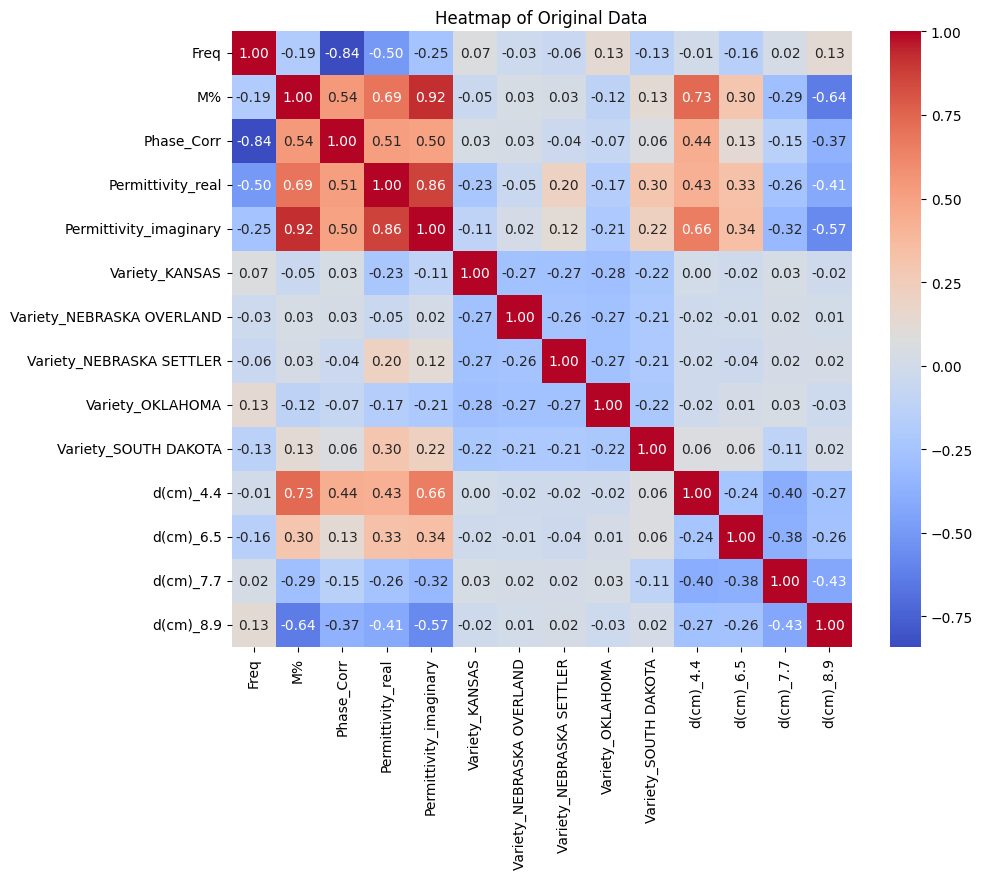

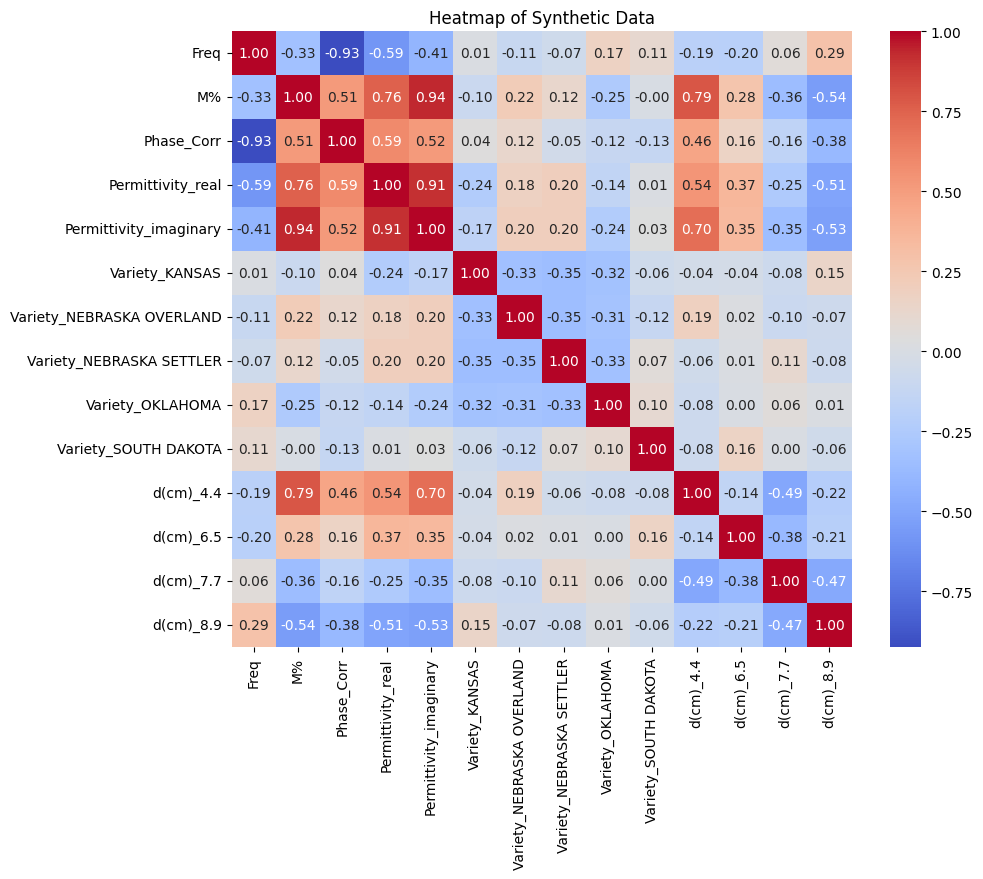

In [58]:
import seaborn as sns  # Import seaborn for heatmap generation
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a mapping of indices back to the original 'd(cm)' categories
d_cm_categories = ['4.4', '6.5', '7.7', '8.9']  # Replace with actual categories
d_cm_columns = [f'd(cm)_{cat}' for cat in d_cm_categories]  # Adjust based on your one-hot encoding

# Assume synthetic_data_rescaled is your generated synthetic data as a numpy array
# Assume df is your original DataFrame that includes the one-hot encoded 'd(cm)' columns

# Function to reverse one-hot encoding for 'd(cm)'
def reverse_one_hot(synthetic_df, original_df_columns, d_cm_columns):
    # Identify the indices of the d(cm) columns in the synthetic data
    indices = [original_df_columns.get_loc(col) for col in d_cm_columns]
    
    # Extract only the d(cm) related columns from the synthetic data
    d_cm_data = synthetic_df[:, indices]
    
    # Convert one-hot encoded data back to categorical labels (assuming the original categories were 0, 1, 2, 3, ...)
    categories = np.argmax(d_cm_data, axis=1)
    
    # Map numeric categories back to original categorical labels if necessary
    # This step depends on how your original categories were defined
    
    return categories

# Columns related to 'd(cm)' one-hot encoding in the DataFrame
d_cm_columns = [col for col in df.columns if 'd(cm)' in col]

# Reverse one-hot encoding for the synthetic data
d_cm_values_synthetic = reverse_one_hot(synthetic_data_rescaled, df.columns, d_cm_columns)

# If necessary, map numeric categories back to original categorical labels
# This mapping should match the one used when initially converting 'd(cm)' to one-hot encoding
category_mapping = {0: 'Category1', 1: 'Category2', 2: 'Category3', 3: 'Category4'}
d_cm_categories_synthetic = np.vectorize(category_mapping.get)(d_cm_values_synthetic)

# Remove one-hot encoded 'd(cm)' columns from synthetic data and add the categorical 'd(cm)'
synthetic_df = pd.DataFrame(synthetic_data_rescaled, columns=df.columns)
for col in d_cm_columns:
    synthetic_df.drop(col, axis=1, inplace=True)
synthetic_df['d(cm)'] = d_cm_categories_synthetic

# Ensure the original DataFrame is prepared similarly if it's not already
# If 'df' has been modified, make sure it has a similar structure to 'synthetic_df'

# Display Heatmaps
def display_heatmap(data, title):
    # Compute the correlation matrix
    corr = data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.show()

# Assuming df is prepared with 'd(cm)' as a single, categorical column
display_heatmap(df, 'Heatmap of Original Data')
display_heatmap(synthetic_df, 'Heatmap of Synthetic Data')

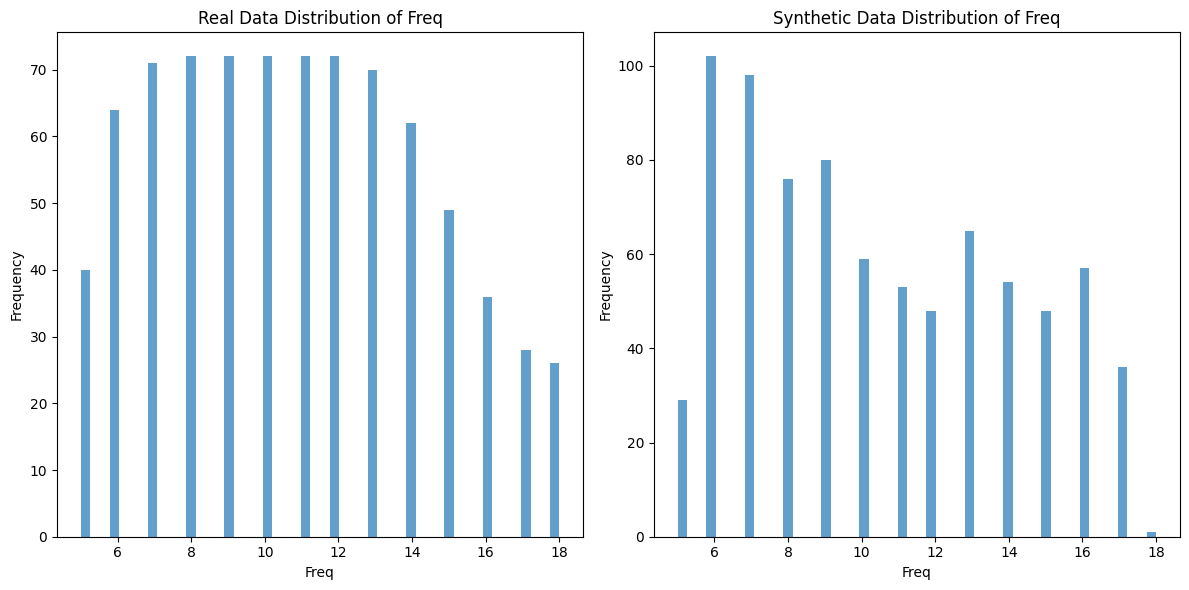

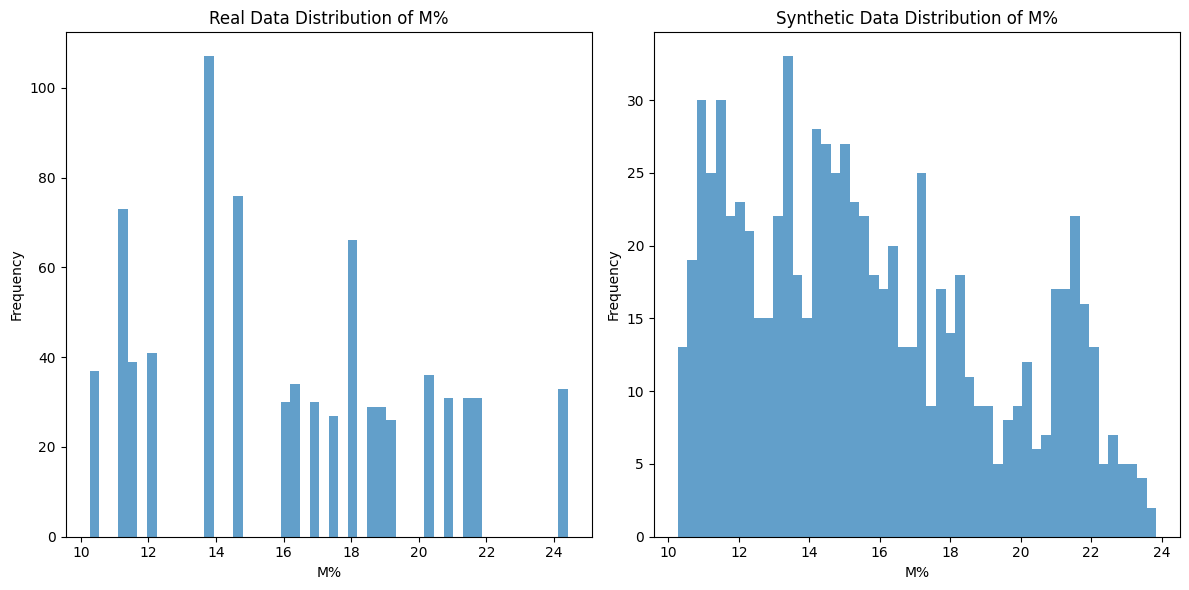

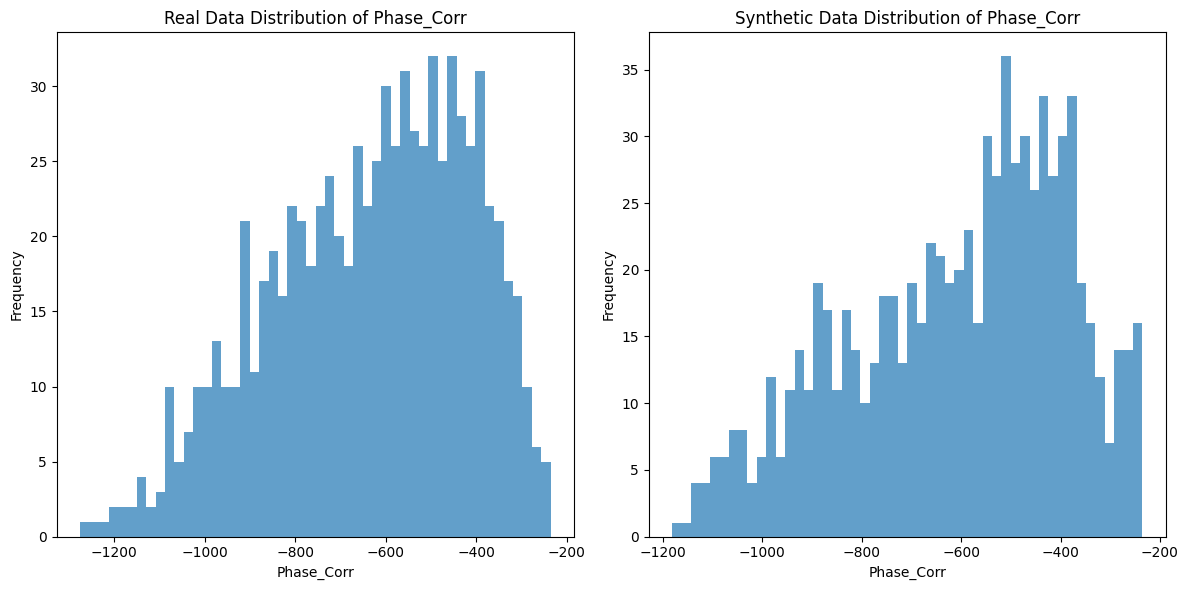

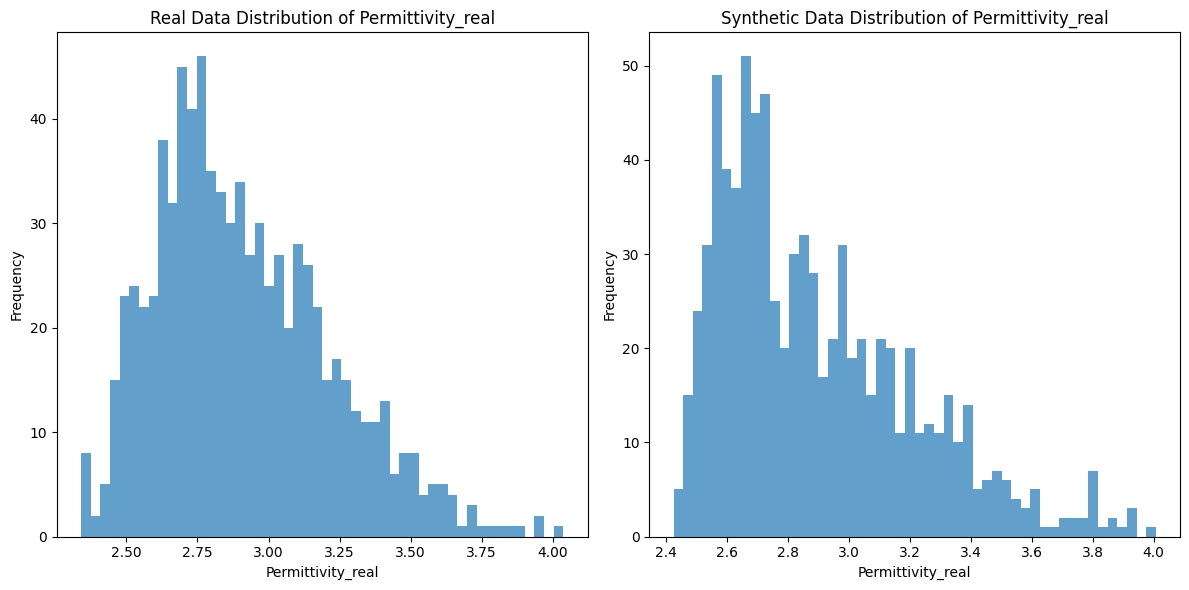

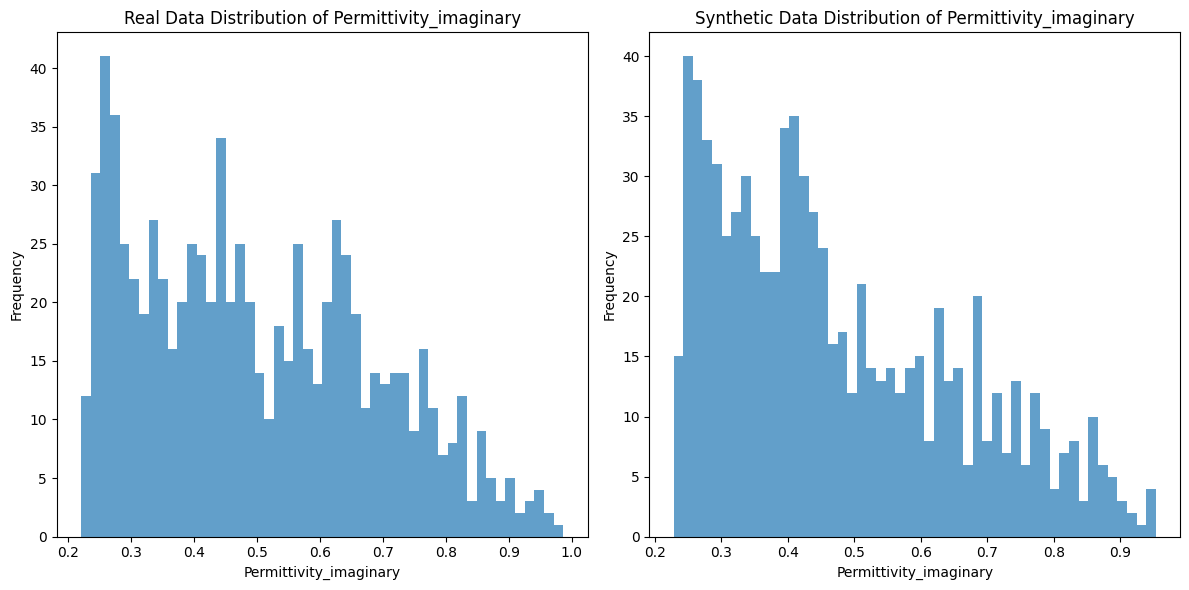

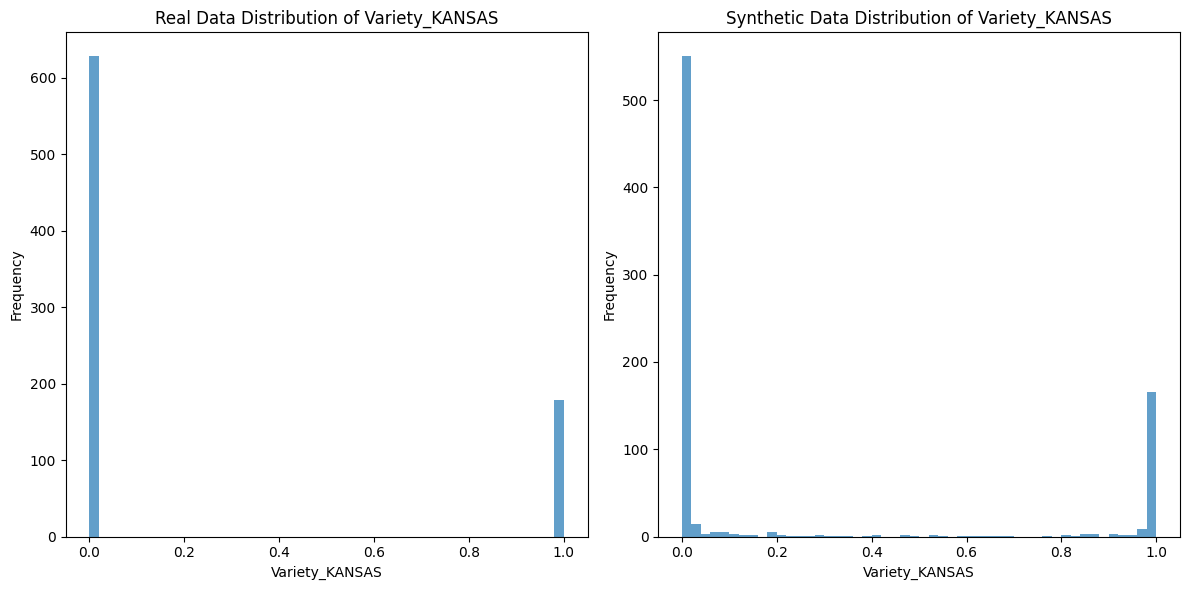

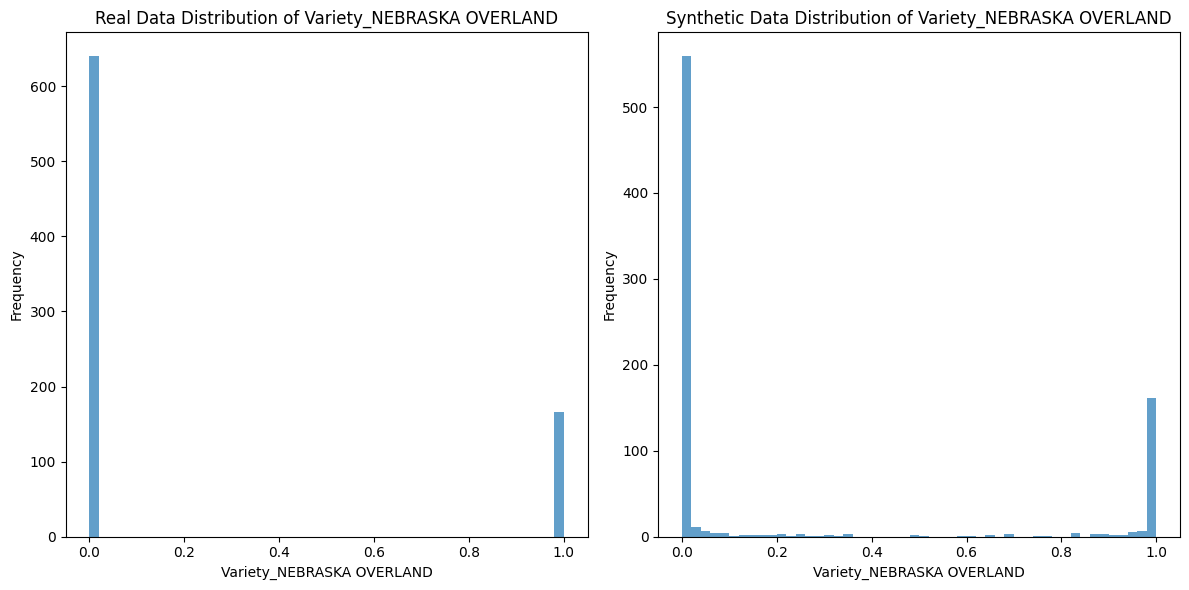

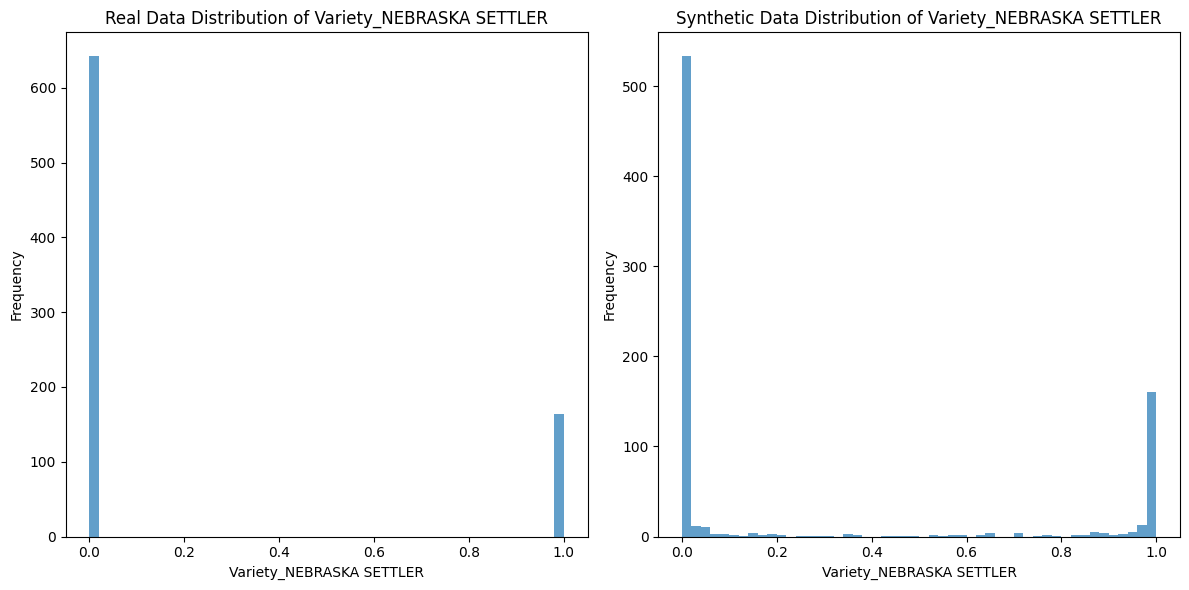

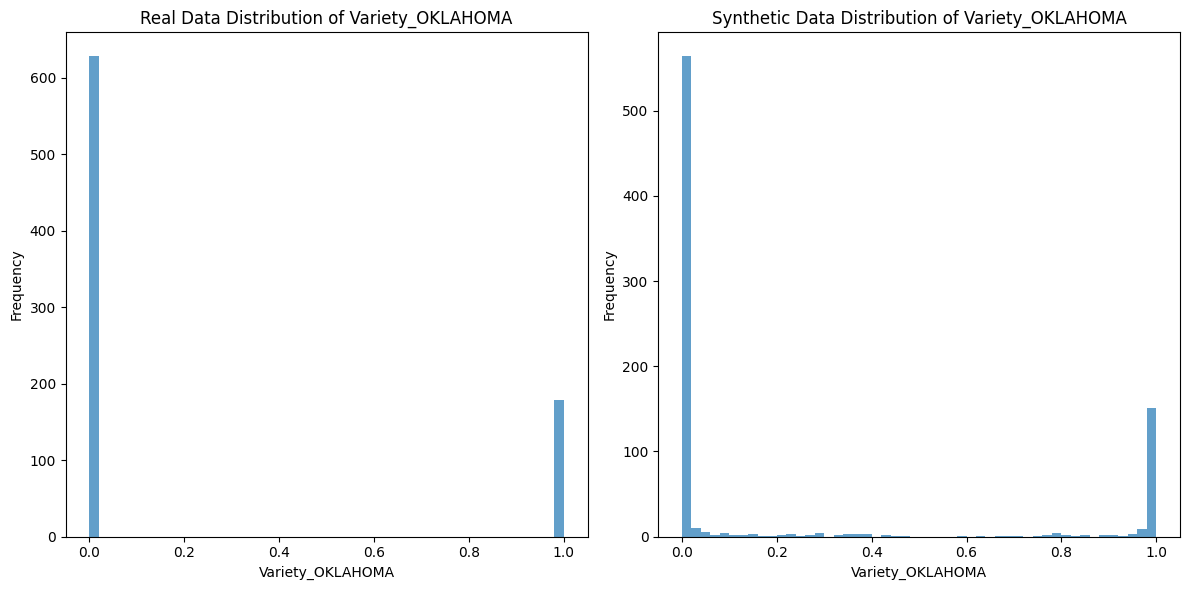

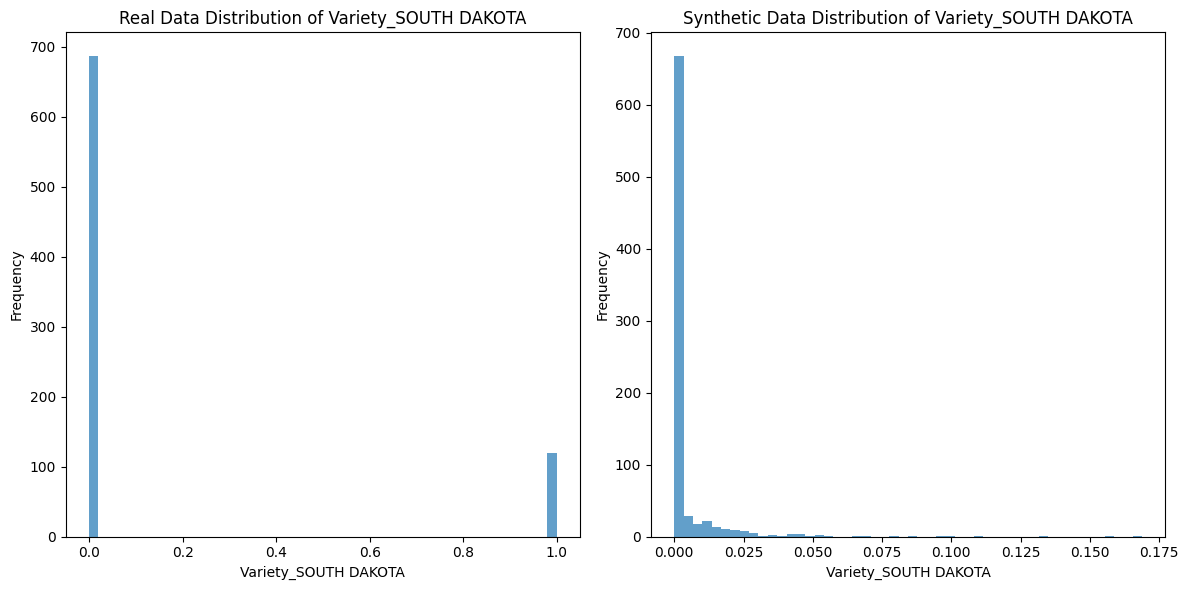

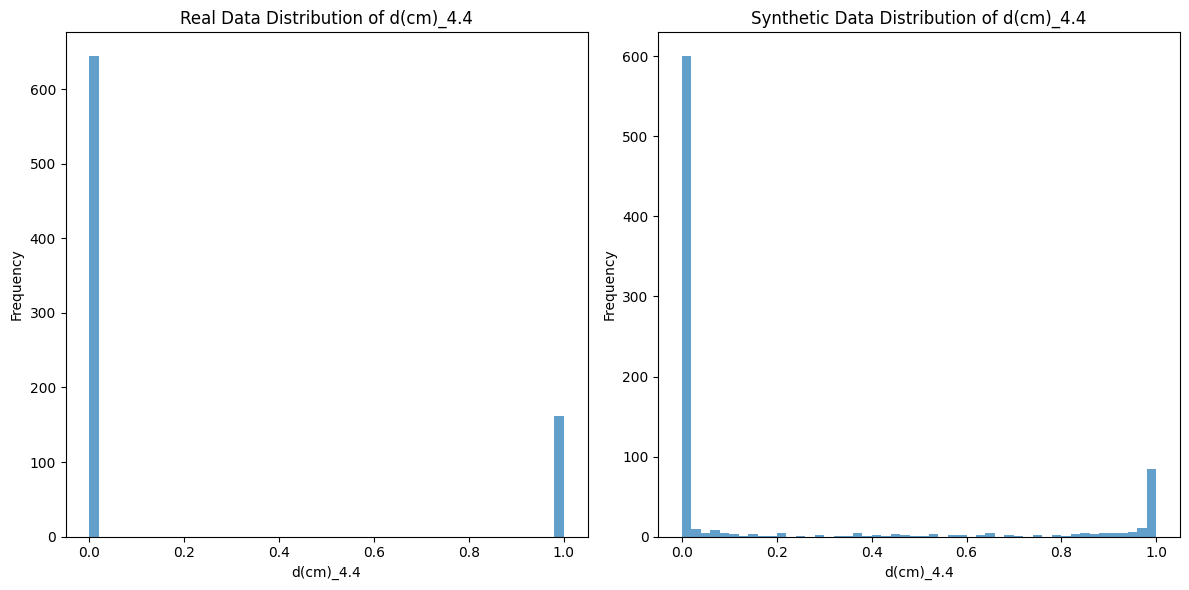

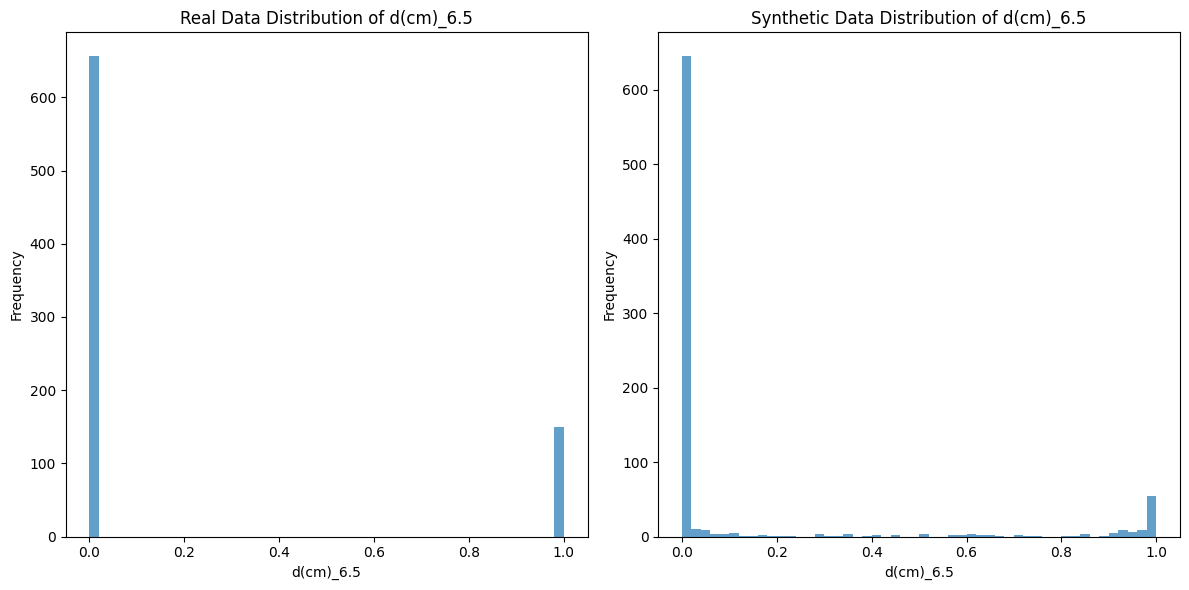

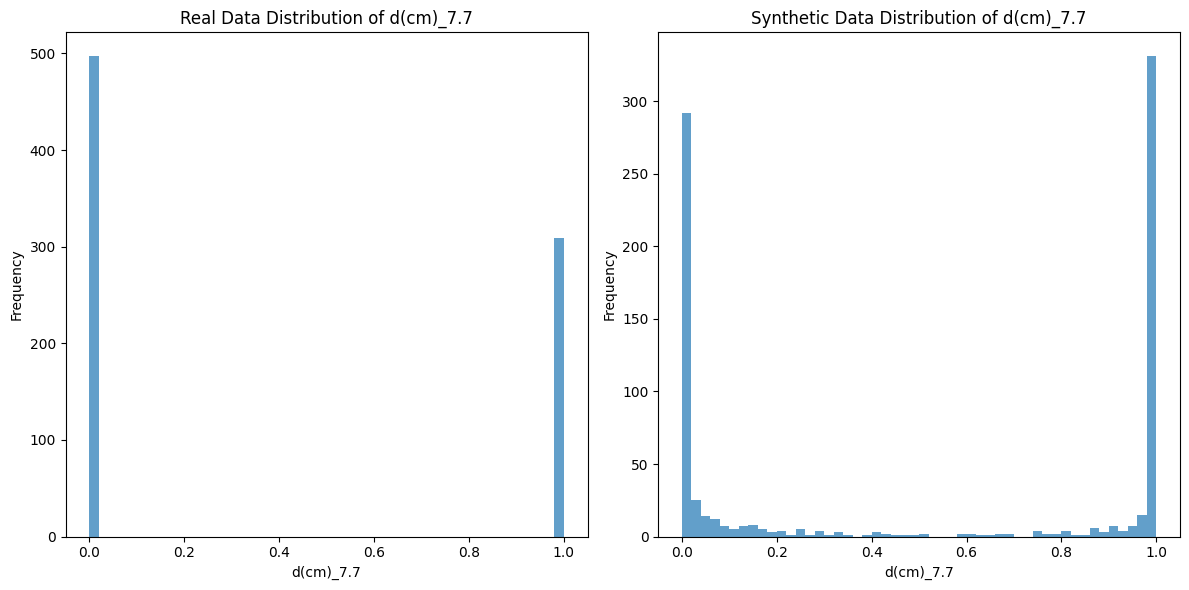

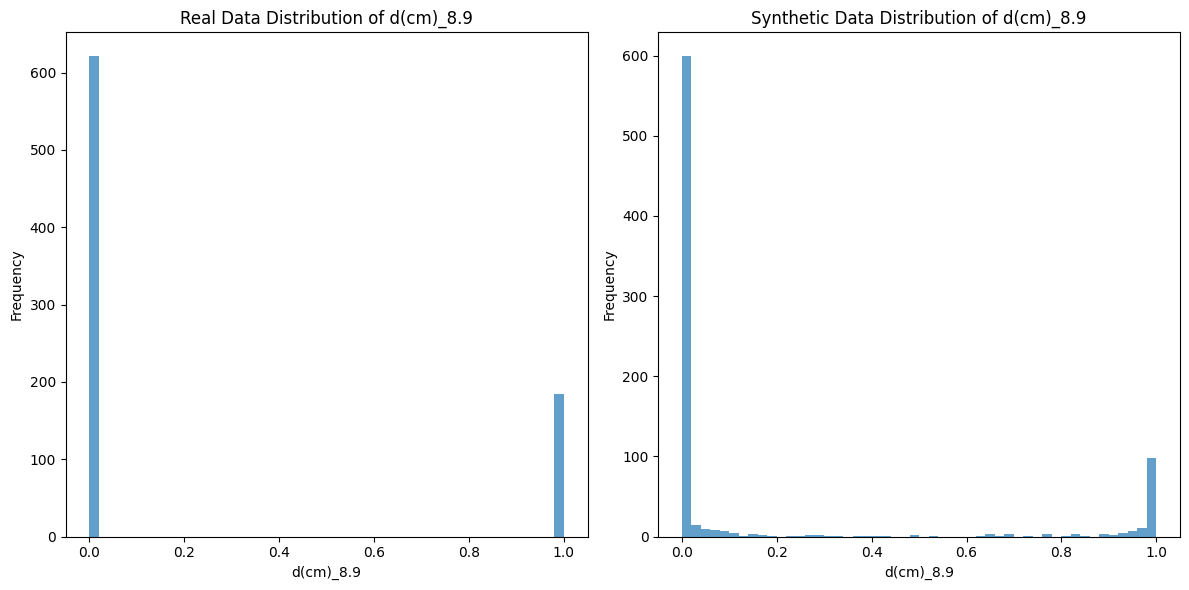

In [29]:
import matplotlib.pyplot as plt

# Assuming 'df' is your real dataset DataFrame and 'synthetic_data_rescaled' is a numpy array of your synthetic data
# Make sure 'synthetic_data_rescaled' is scaled back to the original scale of 'df'

# Iterate over each column in the DataFrame
for feature_name in df.columns:
    feature_index = df.columns.get_loc(feature_name)
    
    # Plotting the distribution of the current feature from both datasets
    plt.figure(figsize=(12, 6))
    
    # Real data
    plt.subplot(1, 2, 1)
    plt.hist(df[feature_name], bins=50, alpha=0.7, label='Real Data')
    plt.title(f'Real Data Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    
    # Synthetic data
    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data_rescaled[:, feature_index], bins=50, alpha=0.7, label='Synthetic Data')
    plt.title(f'Synthetic Data Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


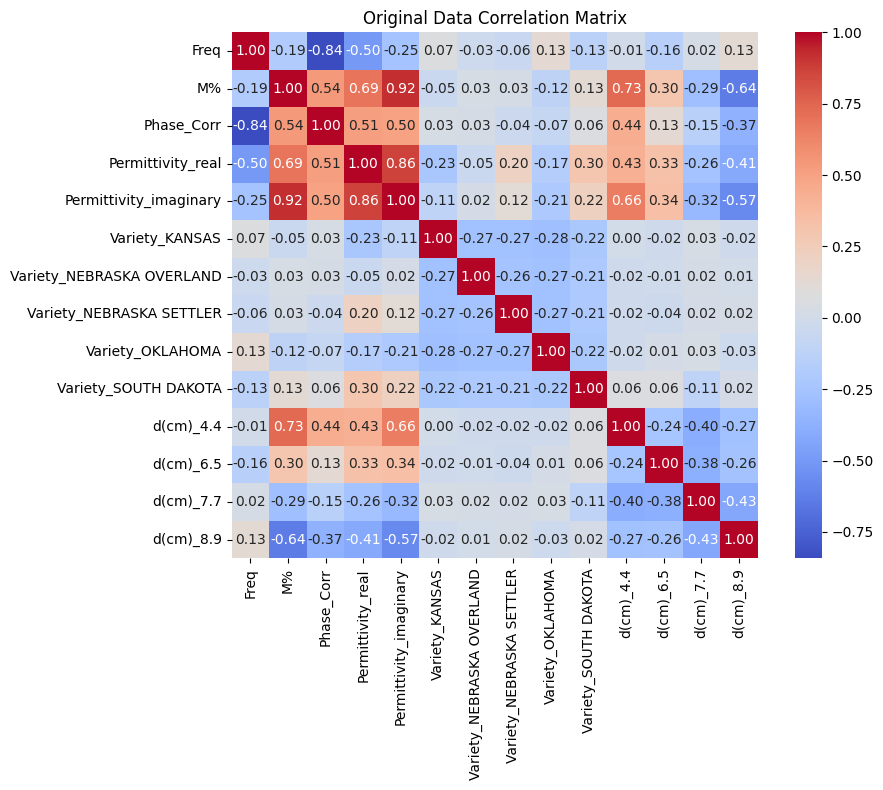

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the synthetic data to a DataFrame with the same column names as the original dataset
synthetic_df = pd.DataFrame(synthetic_data_rescaled, columns=df.columns)

# Calculate the correlation matrices for both datasets
corr_original = df.corr()
corr_synthetic = synthetic_df.corr()

# Increase the figure size for better readability
plt.figure(figsize=(10, 8))

# Plot the heatmap for the original dataset's correlation matrix on the first line
sns.heatmap(corr_original, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Original Data Correlation Matrix')

# Plot the heatmap for the synthetic dataset's correlation matrix on the second line

plt.tight_layout()  # Adjust layout to not overlap
plt.show()
